In [1]:
import oracledb
import pandas as pd
import numpy as np

# Conexão com o banco de dados Oracle
conn = oracledb.connect(
    user='rm567787',
    password='281083',
    dsn='oracle.fiap.com.br:1521/ORCL'
)
cursor = conn.cursor()
cursor.execute("SELECT * FROM MODELO_TOTEM ")
colunas = [col[0] for col in cursor.description]
dados = cursor.fetchall()

dados = pd.DataFrame(dados, columns=colunas)
print(dados.columns.tolist())


['COD_VIAGEM', 'INICIO_INTERACAO', 'FIM_INTERACAO', 'HORA_INI', 'HORA_FIM', 'TEMPO_SESSAO', 'DATA_PESQUISA', 'DE_PARTIDA', 'PARA_DESTINO', 'TRAJETO', 'DATA_PARTIDA', 'DATA_RETORNO', 'TEMPO_VIAGEM', 'QUANT_ASSENTOS', 'OPERACAO', 'FAIXA_ETARIA', 'TIPO_HOSPEDAGEM', 'MOTIVO_VIAGEM', 'HOSPEDAGEM_CONTRADADA', 'VALOR_PASSAGEM', 'FORMA_PAGAMENTO', 'EMPRESA_PARCEIRA', 'TEMPO_INTERACAO', 'TOQUES_TELA', 'TOQUE_ALTA', 'TOQUE_MEDIA', 'TOQUE_BAIXA', 'CELULAR', 'EMAIL', 'ACEITA_SUGESTAO_IA']


In [2]:

dados['TEMPO_SESSAO'] = pd.to_numeric(dados['TEMPO_SESSAO'], errors='coerce')
# Criar coluna teste_tempo_sessao (condição <= 15 minutos)
dados['TESTE_TEMPO_SESSAO'] = np.where(dados['TEMPO_SESSAO']<=15, 1, 0)

# Criar coluna teste_efetividade_venda (condição forma_pagamento != "cotacao")
dados['TESTE_SUCESSO_VENDA'] = np.where(dados['FORMA_PAGAMENTO']!="cotacao", 1, 0)



In [3]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# Selecionar variáveis explicativas
X = dados[['TESTE_TEMPO_SESSAO', 'TRAJETO', 'FAIXA_ETARIA', 'TIPO_HOSPEDAGEM', 'MOTIVO_VIAGEM', 'TOQUES_TELA']]
y = dados['TESTE_SUCESSO_VENDA']

# Transformar variáveis categóricas em dummies
X = pd.get_dummies(X, drop_first=True)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar modelo Decision Tree
modelo = DecisionTreeClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Avaliar desempenho
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Adicionar coluna no DataFrame original para as linhas do teste
dados_novo = dados.copy()
dados_novo['PREDICAO_VENDA'] = np.nan  # cria coluna vazia
dados_novo.loc[X_test.index, 'PREDICAO_VENDA'] = y_pred  # preenche apenas as linhas do teste

# Criar novo DataFrame com base no original (agora com a coluna de predição)
resultado_final = dados_novo.copy()

resultado_final = resultado_final[
    (resultado_final['FORMA_PAGAMENTO'] == 'cotacao') &
    (resultado_final['PREDICAO_VENDA'] == 1) &
    ((resultado_final['CELULAR'].notna()) | (resultado_final['EMAIL'].notna()))
]


# Exibir as primeiras linhas do novo DataFrame
print(resultado_final.to_string())




Acurácia: 0.44666666666666666

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.41      0.43      0.42        69
           1       0.49      0.46      0.47        81

    accuracy                           0.45       150
   macro avg       0.45      0.45      0.45       150
weighted avg       0.45      0.45      0.45       150

     COD_VIAGEM INICIO_INTERACAO     FIM_INTERACAO  HORA_INI  HORA_FIM  TEMPO_SESSAO DATA_PESQUISA      DE_PARTIDA    PARA_DESTINO    TRAJETO DATA_PARTIDA DATA_RETORNO TEMPO_VIAGEM  QUANT_ASSENTOS OPERACAO         FAIXA_ETARIA   TIPO_HOSPEDAGEM     MOTIVO_VIAGEM HOSPEDAGEM_CONTRADADA  VALOR_PASSAGEM FORMA_PAGAMENTO EMPRESA_PARCEIRA TEMPO_INTERACAO  TOQUES_TELA  TOQUE_ALTA  TOQUE_MEDIA  TOQUE_BAIXA        CELULAR            EMAIL ACEITA_SUGESTAO_IA  TESTE_TEMPO_SESSAO  TESTE_SUCESSO_VENDA  PREDICAO_VENDA
17          143   18/11/25 21:00  18/11/2025 21:10  21:00:00  00:10:00            10    2025-11-18      

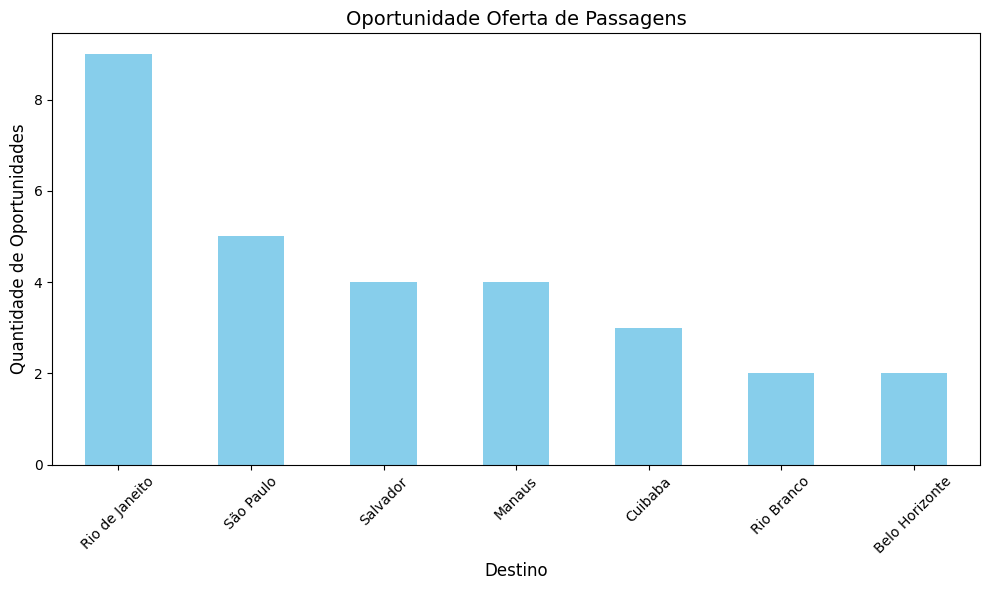

In [4]:

import matplotlib.pyplot as plt

# Contar quantas oportunidades por destino
contagem_destinos = resultado_final['PARA_DESTINO'].value_counts()

# Criar gráfico de barras
plt.figure(figsize=(10, 6))
contagem_destinos.plot(kind='bar', color='skyblue')

# Título e rótulos
plt.title('Oportunidade Oferta de Passagens', fontsize=14)
plt.xlabel('Destino', fontsize=12)
plt.ylabel('Quantidade de Oportunidades', fontsize=12)
plt.xticks(rotation=45)

# Exibir gráfico
plt.tight_layout()
plt.show()


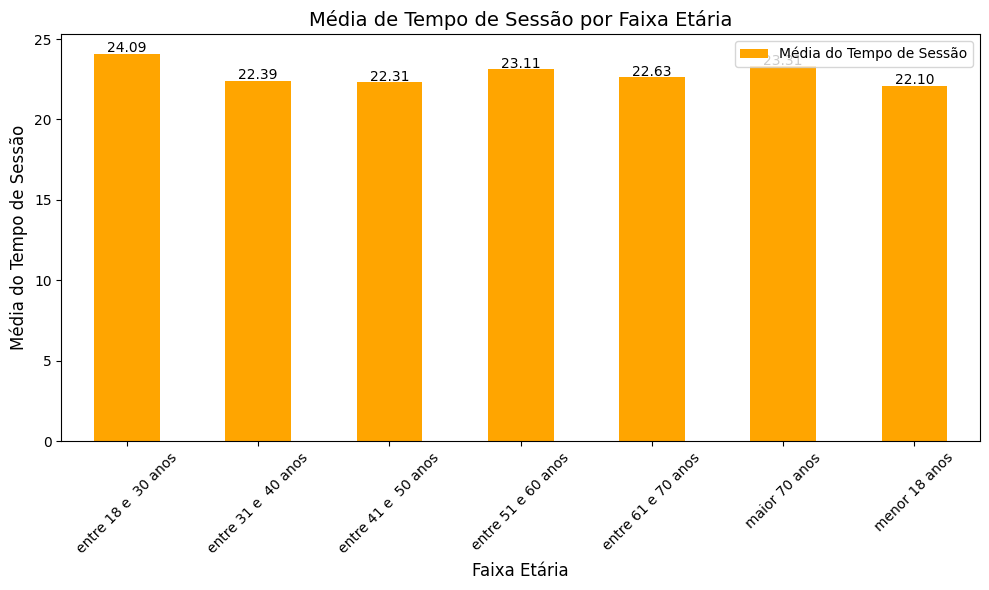

In [5]:

import matplotlib.pyplot as plt

# Calcular a média de TEMPO_SESSAO por FAIXA_ETARIA
media_tempo = dados.groupby('FAIXA_ETARIA')['TEMPO_SESSAO'].mean().sort_index()

# Criar gráfico de barras
plt.figure(figsize=(10, 6))
ax = media_tempo.plot(kind='bar', color='orange', label='Média do Tempo de Sessão')

# Título e rótulos
plt.title('Média de Tempo de Sessão por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Média do Tempo de Sessão', fontsize=12)
plt.xticks(rotation=45)

# Adicionar legenda
plt.legend(loc='upper right')

# Adicionar rótulos com valores no topo das barras
for i, valor in enumerate(media_tempo):
    plt.text(i, valor + 0.1, f'{valor:.2f}', ha='center', fontsize=10)

# Ajustar layout e exibir
plt.tight_layout()
plt.show()


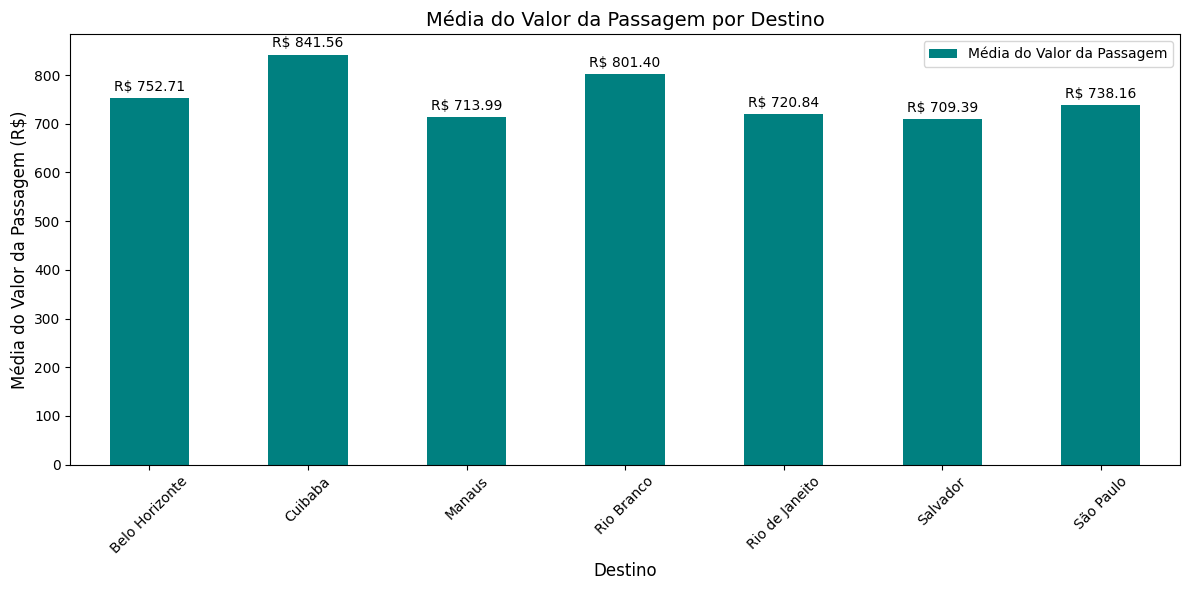

In [6]:

import matplotlib.pyplot as plt

# Consolidar a média de VALOR_PASSAGEM por PARA_DESTINO
media_valor = dados.groupby('PARA_DESTINO')['VALOR_PASSAGEM'].mean().sort_index()

# Criar gráfico de barras
plt.figure(figsize=(12, 6))
ax = media_valor.plot(kind='bar', color='teal', label='Média do Valor da Passagem')

# Título e rótulos
plt.title('Média do Valor da Passagem por Destino', fontsize=14)
plt.xlabel('Destino', fontsize=12)
plt.ylabel('Média do Valor da Passagem (R$)', fontsize=12)
plt.xticks(rotation=45)

# Adicionar legenda
plt.legend(loc='upper right')

# Adicionar rótulos com valores no topo das barras
for i, valor in enumerate(media_valor):
    plt.text(i, valor + (valor * 0.02), f'R$ {valor:.2f}', ha='center', fontsize=10)

# Ajustar layout e exibir
plt.tight_layout()
plt.show()


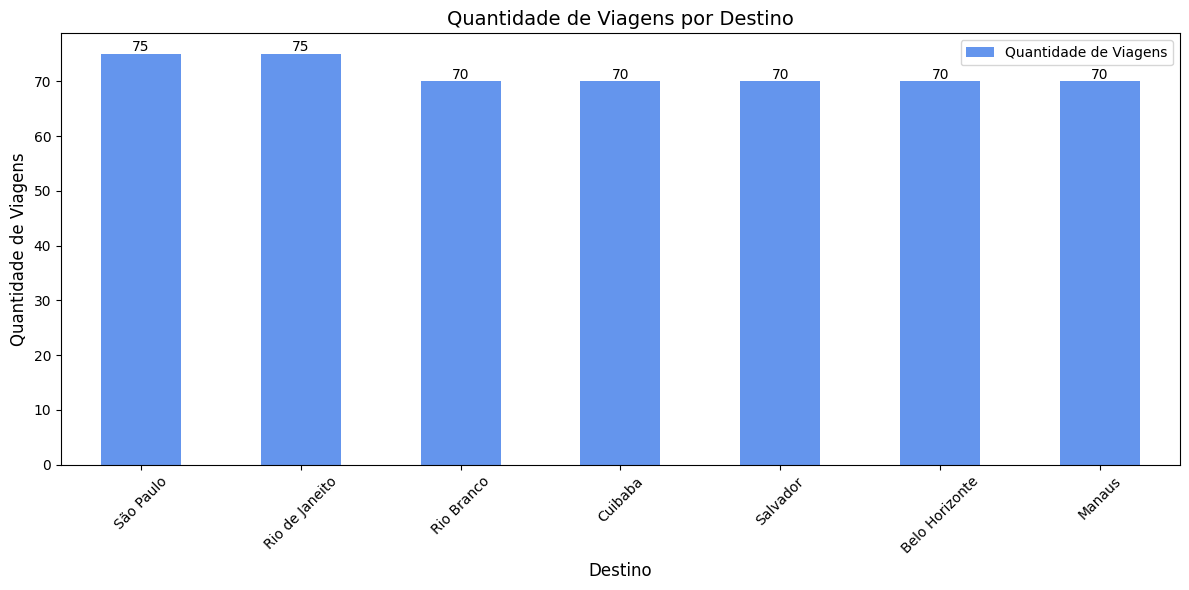

In [7]:

import matplotlib.pyplot as plt

# Contar quantidade de viagens por destino
contagem_viagens = dados['PARA_DESTINO'].value_counts()

# Criar gráfico de barras
plt.figure(figsize=(12, 6))
ax = contagem_viagens.plot(kind='bar', color='cornflowerblue', label='Quantidade de Viagens')

# Título e rótulos
plt.title('Quantidade de Viagens por Destino', fontsize=14)
plt.xlabel('Destino', fontsize=12)
plt.ylabel('Quantidade de Viagens', fontsize=12)
plt.xticks(rotation=45)

# Adicionar legenda
plt.legend(loc='upper right')

# Adicionar rótulos com valores no topo das barras
for i, valor in enumerate(contagem_viagens):
    plt.text(i, valor + 0.5, str(valor), ha='center', fontsize=10)

# Ajustar layout e exibir
plt.tight_layout()
plt.show()


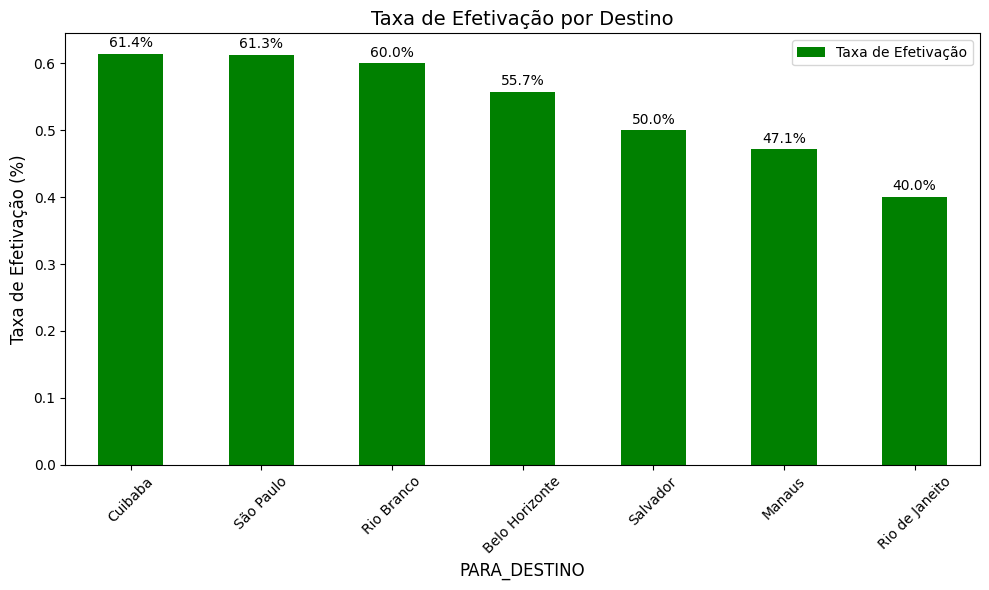

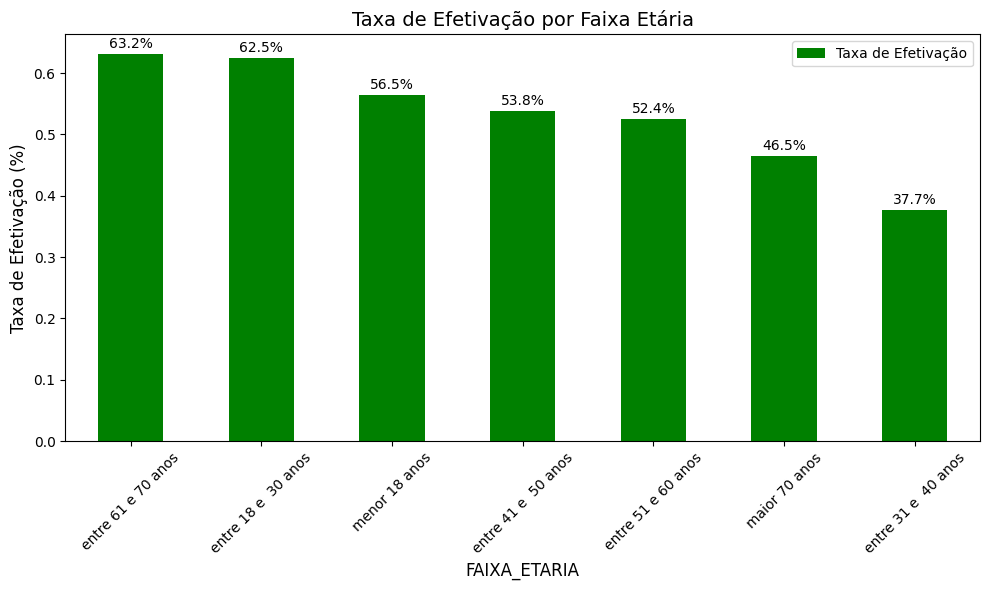

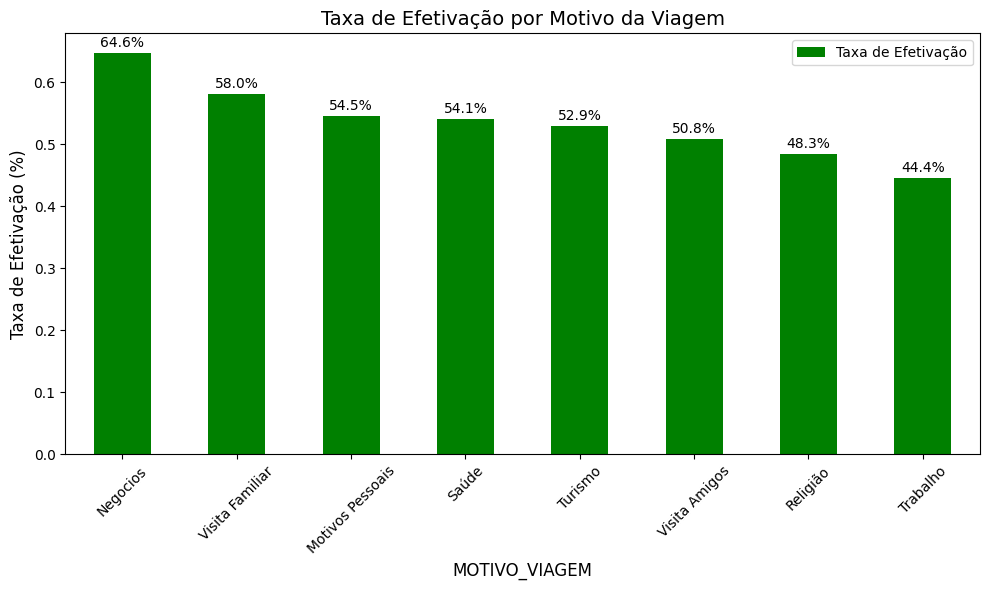

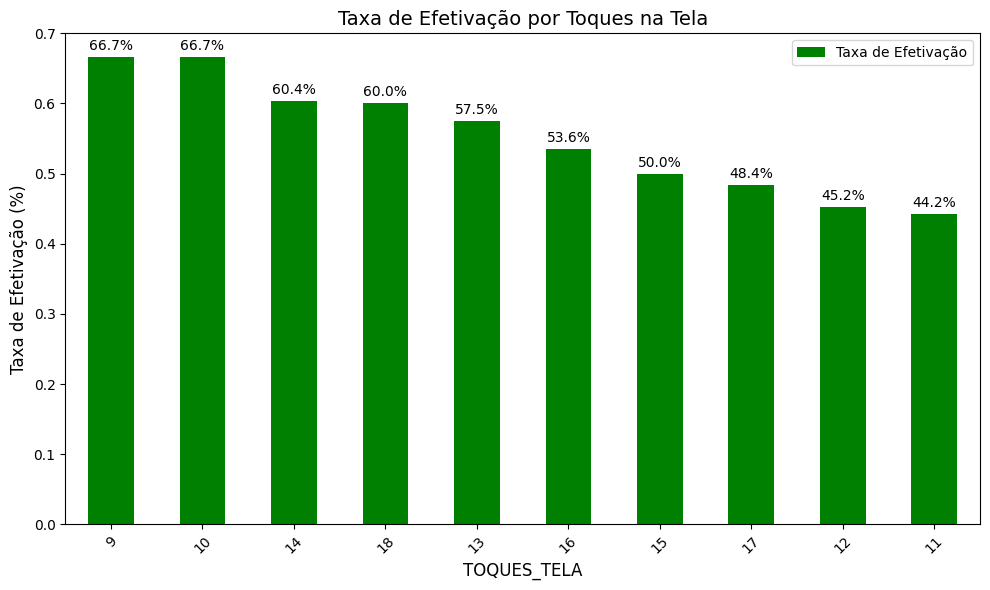

In [8]:

import matplotlib.pyplot as plt

# Função para calcular taxa de efetivação por uma coluna e gerar gráfico
def grafico_taxa_efetivacao(df, coluna, titulo):
    # Calcular taxa: soma dos sucessos dividido pelo total por grupo
    taxa = df.groupby(coluna)['TESTE_SUCESSO_VENDA'].mean().sort_values(ascending=False)
    
    # Criar gráfico de barras
    plt.figure(figsize=(10, 6))
    ax = taxa.plot(kind='bar', color='green', label='Taxa de Efetivação')
    
    # Título e rótulos
    plt.title(titulo, fontsize=14)
    plt.xlabel(coluna, fontsize=12)
    plt.ylabel('Taxa de Efetivação (%)', fontsize=12)
    plt.xticks(rotation=45)
    
    # Adicionar legenda
    plt.legend(loc='upper right')
    
    # Adicionar rótulos com valores no topo das barras
    for i, valor in enumerate(taxa):
        plt.text(i, valor + 0.01, f'{valor*100:.1f}%', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Gerar gráficos para cada visão
grafico_taxa_efetivacao(dados, 'PARA_DESTINO', 'Taxa de Efetivação por Destino')
grafico_taxa_efetivacao(dados, 'FAIXA_ETARIA', 'Taxa de Efetivação por Faixa Etária')
grafico_taxa_efetivacao(dados, 'MOTIVO_VIAGEM', 'Taxa de Efetivação por Motivo da Viagem')
grafico_taxa_efetivacao(dados, 'TOQUES_TELA', 'Taxa de Efetivação por Toques na Tela')


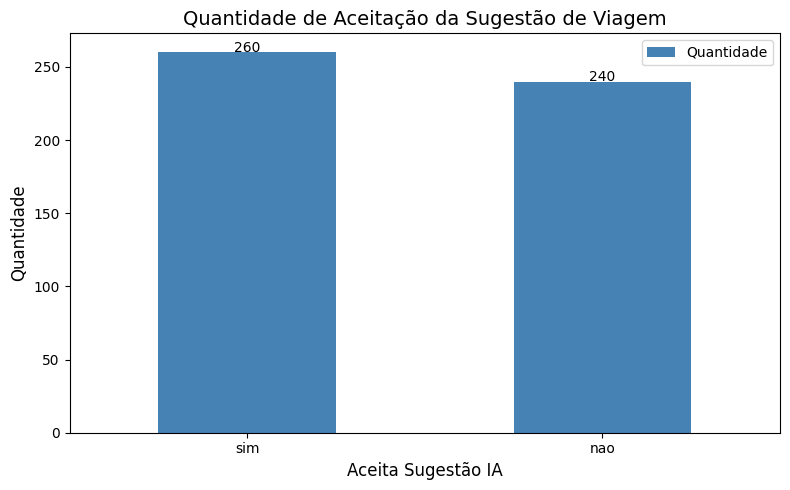

In [9]:

import matplotlib.pyplot as plt

# Contar quantidade de ocorrências na coluna ACEITA_SUGESTAO_IA
contagem = dados['ACEITA_SUGESTAO_IA'].value_counts()

# Criar gráfico de barras
plt.figure(figsize=(8, 5))
ax = contagem.plot(kind='bar', color='steelblue', label='Quantidade')

# Título e rótulos
plt.title('Quantidade de Aceitação da Sugestão de Viagem', fontsize=14)
plt.xlabel('Aceita Sugestão IA', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)

# Adicionar legenda
plt.legend(loc='upper right')

# Adicionar rótulos com valores no topo das barras
for i, valor in enumerate(contagem):
    plt.text(i, valor + 0.5, str(valor), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np

dados['PESQUISA_IA'] = np.where(
    dados['ACEITA_SUGESTAO_IA'].str.upper() == 'SIM',
    (
        'Destino: ' + dados['PARA_DESTINO'].astype(str) +
        ' |Data: ' + dados['DATA_PARTIDA'].astype(str) +
        ' |Tempo Viagem: ' + dados['TEMPO_VIAGEM'].astype(str) +
        ' |Quantidade de Pessoas: ' + dados['QUANT_ASSENTOS'].astype(str) +
        ' |Idade: ' + dados['FAIXA_ETARIA'].astype(str) +
        ' |Motivo da Viagem: ' + dados['MOTIVO_VIAGEM'].astype(str) +
        ' |Hospedagem: ' + dados['TIPO_HOSPEDAGEM'].astype(str)
    ),
    '-'  # Caso contrário
)



# Exibir todo o conteúdo da coluna PESQUISA_IA
pd.set_option('display.max_rows', None)      # Mostra todas as linhas
pd.set_option('display.max_colwidth', None)  # Mostra todo o texto sem truncar

print(dados['PESQUISA_IA'])


0                                                                                                                                                                                           -
1                                  Destino: Cuibaba |Data: 2025-12-12 |Tempo Viagem:  2  |Quantidade de Pessoas: 4 |Idade: entre 31 e  40 anos |Motivo da Viagem: Saúde |Hospedagem: Hospital
2                                                                                                                                                                                           -
3                                                                                                                                                                                           -
4                                         Destino: Salvador |Data: 2025-12-15 |Tempo Viagem:  5  |Quantidade de Pessoas: 4 |Idade: menor 18 anos |Motivo da Viagem: Saúde |Hospedagem: Resort
5                               Destino: Belo Hori